# Overview
***
This fraudulent detection notebook will describe a process to identify fraudulent spirit formulas. We begin by analyzing the linear similarities in wine formulas in order to analyze spirit formulas. Fraudulent formulas will be compared to valid formulas by analyzing how closely one formula resembles propietary formula in the pre-determined dataset.

## Configure the Environment

To configure the environment, the requirements are installed. 

Tools used:
* Numpy - used for scientific computing
* Sci-kit learn - used to generate synthetic clusters
* Matplotlib - used to plot and visualize data
* Scipy - to compute distance between observations in n-dimensional space and convert the vector-form distance to to a square-form distance matrix
* Statistics - used for mean and standard deviation calculations
* Pandas - used to analyze and manipulate data
* Networkx - used to create and manipulate graphs & networks

Since we utilize AWS to store the datasets, credentials and the path to the data files are identified to allow access to the files in the S3 bucket. 

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
import statistics #mean and standard dev measurements
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"]=10,10 #configure plot size

#os.chdir(os.environ['MLDIR'] + '/TestData/formula_fraud/')

boto_session = boto3.Session(aws_access_key_id = '',
                            aws_secret_access_key = '',
                            region_name="us-east-1")
client = boto_session.client('s3',
                            aws_access_key_id = '',
                            aws_secret_access_key = '')

bucket='frauddetectionbucket'
wineKey='formula_fraud/wine.data.csv'
spiritKey='formula_fraud/Synthetic_Formula_Data_Fraud.csv'

## Input Datasets 

The below cell shows the inputs of real wine data and synthetic spirits data. Each column in the wine and spirits datasets represent the ingredients in the wine and spirit formulas. 

**Wine Dataset:** The wine dataset organizes many wine formulas into 3 different groups of wines. The data comes from the following URL: https://archive.ics.uci.edu/ml/datasets/wine.

**Spirits Dataset:** Since real spirit data is propietary, and highly protected, the spirits input dataset is synthetically created to represent formulas of 5 different types of spirits: vodka, rum, whiskey, brandy, and gin. 


In [2]:
# Read Wine dataset

#df_w = pd.read_csv('wine.data.csv')
wine_file = client.get_object(Bucket=bucket, Key=wineKey)
df_w = pd.read_csv(wine_file['Body'])

col_w = []
col_w.append('group') 
col_w.append('alcohol') 
col_w.append('malic_acid') 
col_w.append('ash')
col_w.append('alcalinity')
col_w.append('magnesium')
col_w.append('phenols')
col_w.append('flavanoids')
col_w.append('nonflavanoid_phenol')
col_w.append('proanthcyanins')
col_w.append('color_intensity')
col_w.append('hue')
col_w.append('diluted_wines')
col_w.append('proline')

df_w.columns = col_w

# Read Spirits Dataset
column_names = []
column_names.append('type')
column_names.append('ethyl')
column_names.append('methonal')
column_names.append('glycerol')
column_names.append('propanol')
column_names.append('coumarin')
column_names.append('citric_acid')
column_names.append('acetaldehyde')
column_names.append('isoamyl_alcohol')
column_names.append('impurities')
for i in range(90):
    column_names.append('add_ingredient'+str(i))

spirit_file = client.get_object(Bucket=bucket, Key=spiritKey)
tmp_df = pd.read_csv(spirit_file['Body'])

#tmp_df = pd.read_csv('spirits_train_data.csv')

df_s = pd.DataFrame(tmp_df,columns=column_names)

print('Wine Input Data')
display(df_w.head())
print('Spirits Input Data')
display(df_s.head())

Wine Input Data


,group,alcohol,malic_acid,ash,alcalinity,magnesium,phenols,flavanoids,nonflavanoid_phenol,proanthcyanins,color_intensity,hue,diluted_wines,proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


Spirits Input Data


,type,ethyl,methonal,glycerol,propanol,coumarin,citric_acid,acetaldehyde,isoamyl_alcohol,impurities,...,add_ingredient80,add_ingredient81,add_ingredient82,add_ingredient83,add_ingredient84,add_ingredient85,add_ingredient86,add_ingredient87,add_ingredient88,add_ingredient89
0,1,2.456913,1.254107,1.453961,1.536800,0.481717,0.609271,1.207817,1.654135,2.564021,...,2.156512,2.664057,1.025385,3.122031,1.626412,3.407616,2.602341,2.164176,2.047368,0.767397
1,0,0.057143,2.101622,0.884119,2.704298,1.633250,0.269017,0.843732,0.499406,1.802072,...,1.888515,1.301460,2.517023,2.156765,1.997051,-1.186179,3.323790,2.736919,4.566475,2.812993
2,3,3.134865,0.281609,3.055951,1.363279,1.876124,0.524418,2.213087,1.695274,1.013712,...,0.223124,3.525073,2.763486,0.887910,2.960680,0.632482,0.100387,-0.043816,2.195956,-0.443376
3,4,-0.641115,2.021125,2.283115,0.582500,1.482482,2.104150,1.464874,1.127270,2.235188,...,1.934240,2.055834,2.672527,1.387247,2.535532,1.044288,0.220498,1.997146,3.913699,1.431429
4,0,0.039294,1.706540,0.646560,2.821327,3.059975,2.875435,-0.467113,0.067731,1.330263,...,1.463126,1.130646,3.978197,2.829895,-0.112976,1.179699,2.003402,1.950558,0.627345,1.898897


## Training the Spirits and Wine Models
***
The cell below trains the wine and spirits data models. To train the model, the t-SNE algorithm is used to cluster n-dimensional data. Clustering n-dimensional data is a dimension reduction process. The algorithmn constructs a probability distribution over high-dimensional pairs in a way that similar objects have a higher likelihood of being picked while dissimilar points have an extremely small probabilitity of being picked.

### Why we chose the t-SNE algorithm

* well-suited for high-dimensional data 
* can map the n-dimensions on a 2-D plot

This 2-D plot can be used to analyze if a new formula resembles a valid formula in our pre-determined dataset.


In [3]:
#Train wine data model
np.random.seed(0)
np.set_printoptions(suppress=True)

X_embedded_w = TSNE(n_components=2).fit_transform(df_w)
X_embedded_w = pd.DataFrame(X_embedded_w, columns=['x_val', 'y_val'])

X_embedded_w['type'] = 0
X_embedded_w['type'] = df_w.iloc[:,0]

X_embedded_w.loc[X_embedded_w['type'] == 1, 'type'] = 'wine_1'
X_embedded_w.loc[X_embedded_w['type'] == 2, 'type'] = 'wine_2'
X_embedded_w.loc[X_embedded_w['type'] == 3, 'type'] = 'wine_3'

# Train spirits data model
X_embedded_s = TSNE(n_components=2).fit_transform(df_s)
X_embedded_s = pd.DataFrame(X_embedded_s, columns=['x_val', 'y_val'])
X_embedded_s['type'] = 0
X_embedded_s['type'] = df_s.iloc[:,0]

X_embedded_s.loc[4, 'type'] = 5
X_embedded_s.loc[X_embedded_s['type'] == 0, 'type'] = 'vodka'
X_embedded_s.loc[X_embedded_s['type'] == 1, 'type'] = 'rum'
X_embedded_s.loc[X_embedded_s['type'] == 2, 'type'] = 'whiskey'
X_embedded_s.loc[X_embedded_s['type'] == 3, 'type'] = 'brandy'
X_embedded_s.loc[X_embedded_s['type'] == 4, 'type'] = 'gin'
X_embedded_s.loc[X_embedded_s['type'] == 5, 'type'] = 'fraud_vodka'

# The Output datasets
***
The below cell shows the trained output dataset for the wine and spirits models. The n-dimensional data can now be viewed and analyzed with the 2 principal components. 

In [4]:
# Show trained wine and spirits data 
print('Trained Wine Data')
display(X_embedded_w)
print('Trained Spirit Data')
display(X_embedded_s)
    
    

Trained Wine Data


,x_val,y_val,type
0,-3.349409,9.724936,wine_1
1,-4.586280,11.883982,wine_1
2,-5.489674,14.601624,wine_1
3,-0.066745,2.032235,wine_1
4,-5.432441,14.425921,wine_1
...,...,...,...
172,-0.460050,1.838232,wine_3
173,-0.602522,2.258568,wine_3
174,-1.504775,4.774232,wine_3
175,-1.446244,4.996184,wine_3


Trained Spirit Data


,x_val,y_val,type
0,-7.270823,4.349691,rum
1,-6.300487,-0.927200,vodka
2,3.102633,1.766696,brandy
3,-1.930564,-3.355702,gin
4,-7.248773,-0.758813,fraud_vodka
...,...,...,...
95,-2.538136,3.929602,whiskey
96,-1.212602,-2.545022,gin
97,-2.249686,-3.158100,gin
98,-6.883018,4.573122,rum


## Visualizing the Wine Data
***
This cell visualizes the trained wine data. It shows how wine formulas display linearly. Since wine formulas are mostly grape of some form, the changes in the wine formula will cause a "linear" movement of the changing wine formula. If the wine formula changes in a "non-linear" way, it becomes classified as something other than wine. 

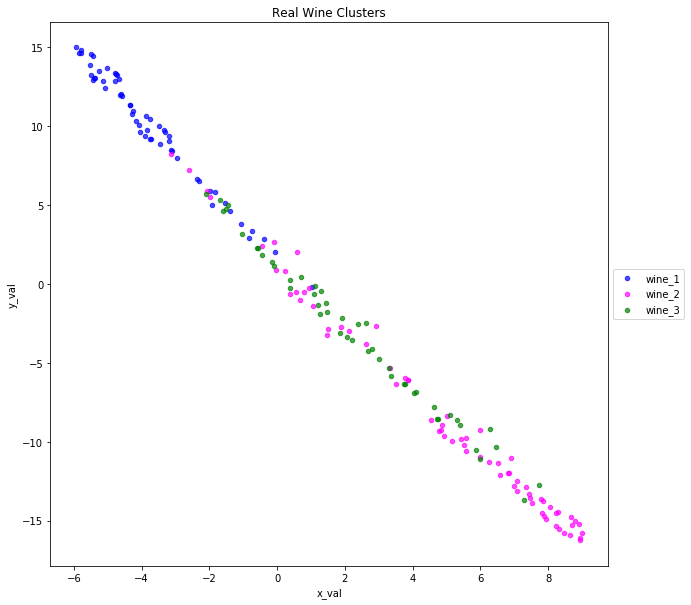

In [7]:
# Show trained wine data 
colors_w = {'wine_1':'blue', 'wine_2':'magenta', 'wine_3':'green', 'brandy':'yellow', 'gin':'brown'}
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grouped_w = X_embedded_w.groupby('type')
for key, group in grouped_w:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors_w[key], alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Real Wine Clusters')
plt.show()

## Visualizing the Spirits Data
***
This cell visualizes the trained spirits data. This visualization dramatizes how spirits would cluster. The wine data was visualized linearly because it was all of the same type of alcohol. Since this dataset includes formulas for vodka, rum, whiskey, brandy, and gin, the data points are generally clustered by the type of alcohol. 

### Identifying a Fraudulent Formula
The red dot in the blue cluster represents a new vodka formula that was submitted. It can be easily detected visually on the graph below. The red dot is very close to a valid, existing vodka formula, indicating that the "fraud_vodka" formula is most likely a replica of a propietary formula.

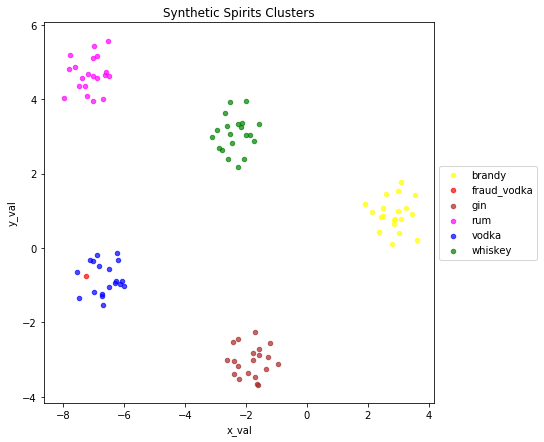

In [6]:
colors = {'vodka':'blue', 'rum':'magenta', 'whiskey':'green', 'brandy':'yellow', 'gin':'brown', 'fraud_vodka':'red'}

fig, ax = plt.subplots(1,1, figsize=(7, 7))
grouped_s = X_embedded_s.groupby('type')
for key, group in grouped_s:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors[key], alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Synthetic Spirits Clusters')
plt.show()